# Single Object Detection

The notebook illustrates how the SquiDS package can help to create and test a single object detection model.

**Please note that the goal of this notebook is not to create the perfect ML model, but to demonstrate how to use the functionality of the SquiDS package.**

In [1]:
import sys
sys.path.insert(0, '..')

from PIL import ImageDraw, ImageFont
import tensorflow as tf
import numpy as np

from squids import (
    create_dataset,
    create_tfrecords,
    explore_tfrecords,
    load_tfrecords,
    Palette,
    Background
)

from helper import plot_images

## Preparing Dataset

Generate synthetic dataset and convert it to TFRecords.

In [2]:
create_dataset(
    dataset_size=10000,
    image_palette=Palette.BINARY,
    image_background=Background.BLACK,
    random_state=365,
    image_capacity=1,
    verbose=True)
create_tfrecords(
    verbose=True)

100%|██████████| 999/999 [00:00<00:00, 1236.87it/s]


Explore few samples from the generated dataset.

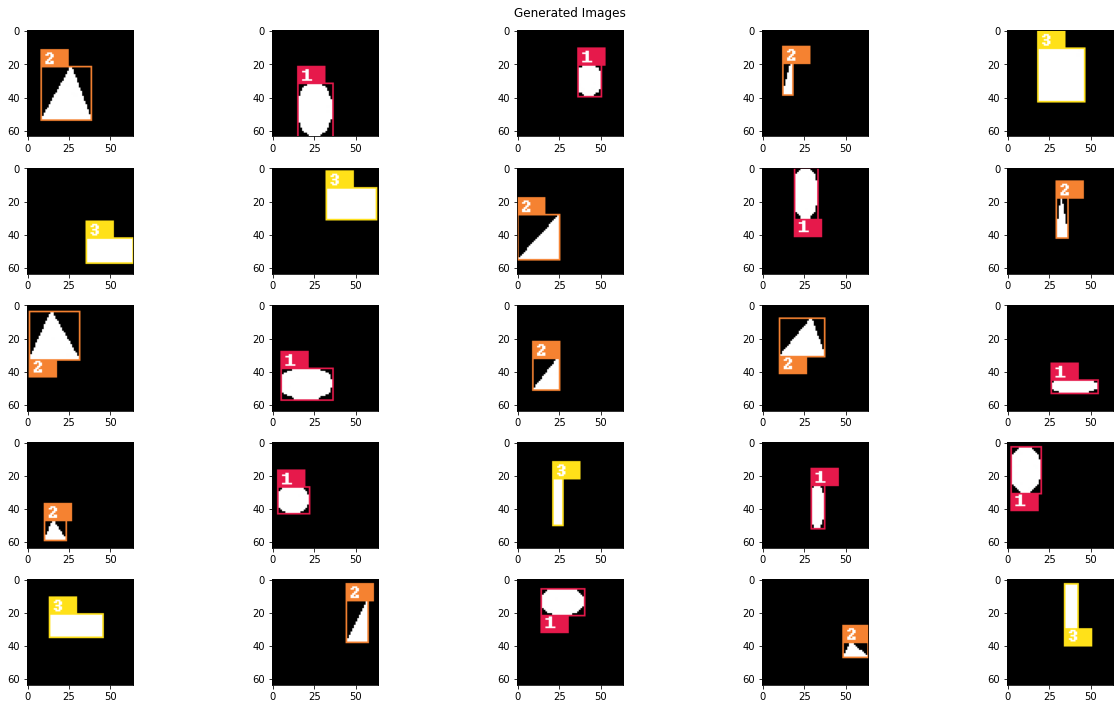

In [5]:
image_ids, _ = explore_tfrecords(
    'dataset/synthetic-tfrecords/instances_train',
    return_artifacts=True
)

images  = [
    explore_tfrecords(
        'dataset/synthetic-tfrecords/instances_train',
        image_id,
        with_categories=True,
        with_bboxes=True,
        return_artifacts=True
    )[0]
    for image_id in image_ids[0:25]
]

plot_images(images, "Generated Images")

## Train Object Detection Model

Let's create generators for train and validation datasets and compute steps per epoch for each of them. 

Note:
1. For this model we need to combine bounding boxes and categories one-hot encodings. We can do it by using the `BC` output schema.
2. The number of detecting objects is 1.

In [3]:
ds_train, train_steps_per_epoch = load_tfrecords(
    "dataset/synthetic-tfrecords/instances_train", 
    output_schema = "BC",
    num_detecting_objects=1,
)
print(
    "Training steps per epoch (for the default batch size 32):",
    train_steps_per_epoch
)

ds_val, val_steps_per_epoch = load_tfrecords(
    "dataset/synthetic-tfrecords/instances_val", 
    output_schema = "BC",
    num_detecting_objects=1,
)
print(
    "Validation steps per epoch (for the default batch size 32):",
    val_steps_per_epoch
)

2022-02-20 23:02:49.514914: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled
2022-02-20 23:02:49.814367: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Training steps per epoch (for the default batch size 32): 219
Validation steps per epoch (for the default batch size 32): 63


Let's define a simple convolution model.

In [20]:
localizer = tf.keras.models.Sequential([
	tf.keras.layers.Dense(
		1024, 
		kernel_initializer='random_normal',
		bias_initializer='zeros',
		activation='relu',
        input_shape=(1024,)),
	tf.keras.layers.Dense(
		4,
		activation='relu')
])

classifier = tf.keras.models.Sequential([
	tf.keras.layers.Dense(
		1024, 
		kernel_initializer='random_normal',
		bias_initializer='zeros',
		activation='relu',
        input_shape=(1024,)),
	tf.keras.layers.Dense(
		4,
		activation='softmax'),
	tf.keras.layers.Lambda(lambda x: x * 10)
])

common = tf.keras.models.Sequential([
	tf.keras.layers.Conv2D(
			filters=32,
            kernel_size=(3, 3),
            padding='same',
            input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(
            pool_size=(2, 2)),
	tf.keras.layers.Conv2D(
			filters=64,
            kernel_size=(3, 3),
            padding='same',
            input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(
            pool_size=(2, 2)),
	tf.keras.layers.Conv2D(
			filters=128,
            kernel_size=(3, 3),
            padding='same',
            input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(
            pool_size=(2, 2)),
	tf.keras.layers.Conv2D(
			filters=256,
            kernel_size=(3, 3),
            padding='same',
            input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(
            pool_size=(2, 2)),
	tf.keras.layers.Flatten(),
	tf.keras.layers.Dense(
		1024, 
		kernel_initializer='random_normal',
		bias_initializer='zeros',
		activation='relu'),
])

model_input = common.input
x = common(model_input)
model_output = tf.keras.layers.Concatenate()(
	[localizer(x), classifier(x)])
model = tf.keras.models.Model(model_input, model_output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.mean_squared_error,
)

Now we are ready to perform the model training. Note that the best model weights are stored in the `best_weights.h5` file.

In [21]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "best_weights.h5",
    monitor='val_loss',
    mode="min",
    save_best_only=True,
    verbose=1)
model.fit(
    ds_train,
    steps_per_epoch = train_steps_per_epoch,
    epochs=50,
    validation_data=ds_val,
    validation_steps = val_steps_per_epoch,
    callbacks=checkpoint_callback,
    verbose=1
)

Epoch 1/50
216/219 [============================>.] - ETA: 0s - loss: 16.5152
Epoch 1: val_loss improved from inf to 3.40157, saving model to best_weights.h5
219/219 [==============================] - 6s 25ms/step - loss: 16.3340 - val_loss: 3.4016
Epoch 2/50
217/219 [============================>.] - ETA: 0s - loss: 3.1769
Epoch 2: val_loss improved from 3.40157 to 3.35834, saving model to best_weights.h5
219/219 [==============================] - 5s 22ms/step - loss: 3.1769 - val_loss: 3.3583
Epoch 3/50
216/219 [============================>.] - ETA: 0s - loss: 2.8845
Epoch 3: val_loss improved from 3.35834 to 2.83014, saving model to best_weights.h5
219/219 [==============================] - 4s 21ms/step - loss: 2.8826 - val_loss: 2.8301
Epoch 4/50
218/219 [============================>.] - ETA: 0s - loss: 2.9268
Epoch 4: val_loss did not improve from 2.83014
219/219 [==============================] - 4s 19ms/step - loss: 2.9262 - val_loss: 2.9550
Epoch 5/50
218/219 [===============

## Test Object Detection Model

Let's test the model on the unseen data.

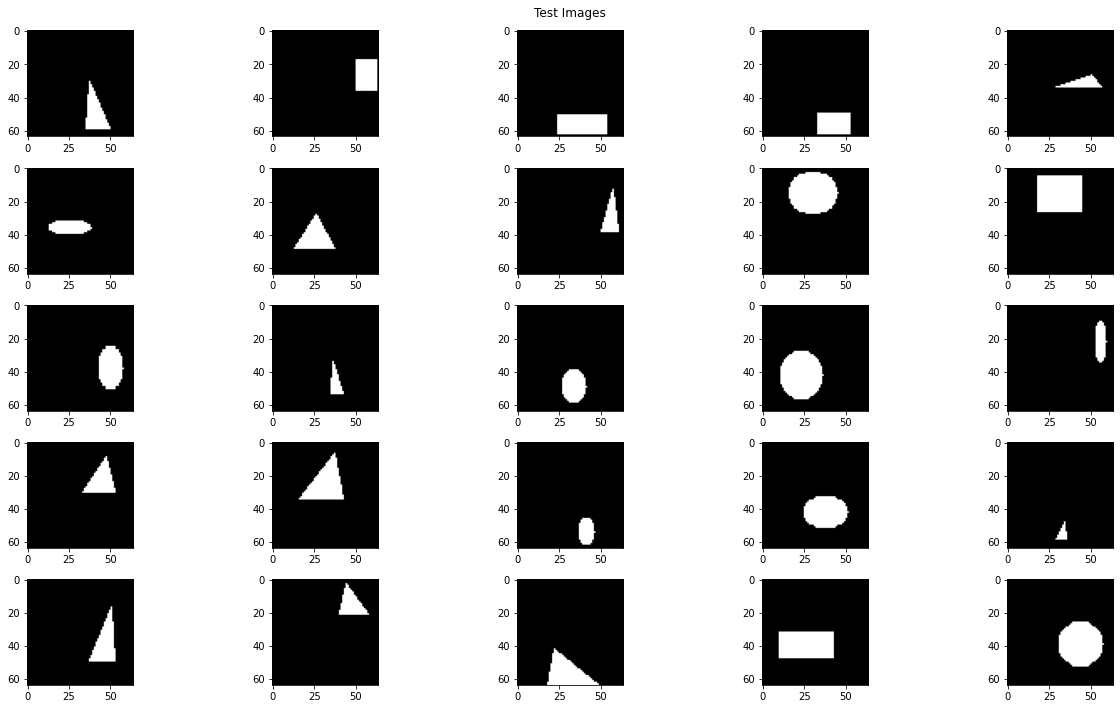

In [22]:
image_ids, _ = explore_tfrecords(
    'dataset/synthetic-tfrecords/instances_test',
    return_artifacts=True
)

images  = [
    explore_tfrecords(
        'dataset/synthetic-tfrecords/instances_test',
        image_id,
        return_artifacts=True
    )[0]
    for image_id in image_ids[0:25]
]

plot_images(images, "Test Images")

Make model prediction and overlay results on the test images.

Categories ID:
- 0 - Ellipse;
- 1 - Triangle;
- 2 - Rectangle;

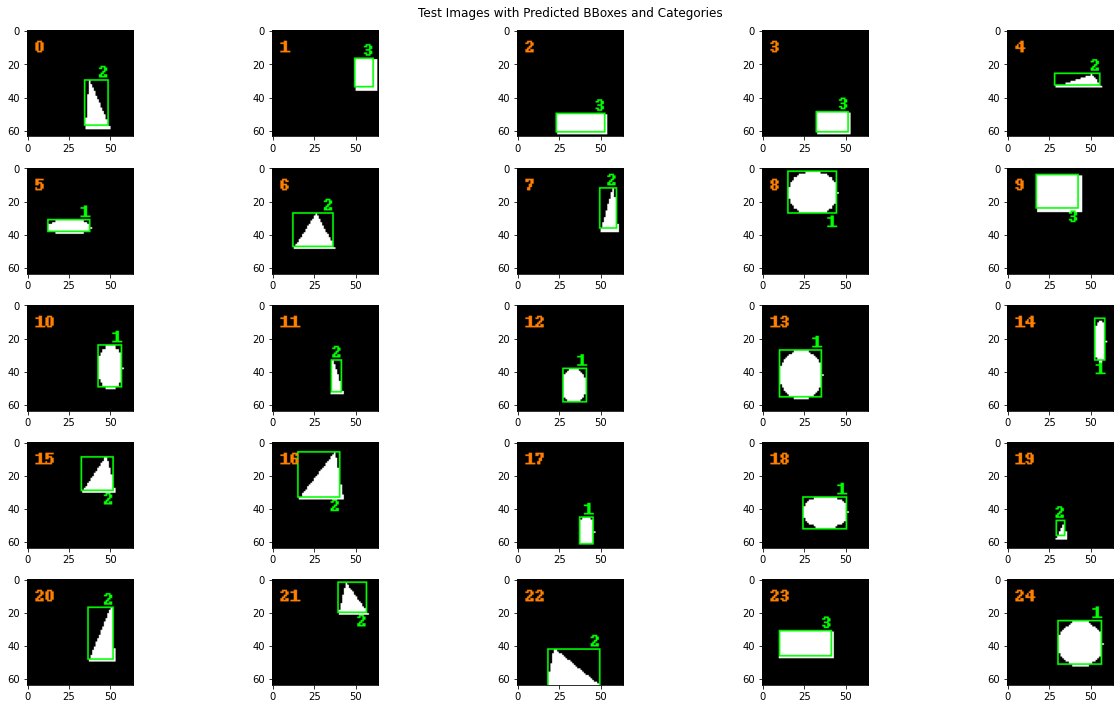

In [23]:
preprocessed_images = np.array(
    [np.array(image) for image in images]
) / 255.0

model.load_weights("best_weights.h5")
predictions = model.predict(preprocessed_images)

sample = 0
for image, prediction in zip(images, predictions):
    draw = ImageDraw.Draw(image)

    bbox = prediction[:4].astype(int)
    category_id = np.argmax(prediction[4:])
    if category_id > 0:
        x, y, w, h = bbox
        draw.rectangle(
            (x, y, x + w, y + h),
            outline="#00FF00"
        )
        if bbox[1] < 10:
            draw.text(
                (x + w - 5, y + h),
                str(category_id),
                "#00FF00",
                font=ImageFont.load_default(),
            )
        else:
            draw.text(
                (x + w - 5, y - 10),
                str(category_id),
                "#00FF00",
                font=ImageFont.load_default(),
            )
    draw.text(
        (5,5),
        str(sample),
        "#FF8000",
        font=ImageFont.load_default(),
    )
    sample += 1

plot_images(images, "Test Images with Predicted BBoxes and Categories")